# LSTM Architectures on Amazon Reviews Dataset (Part II)

## Amazon Fine Food Review Dataset


**Data Source:** <br>https://www.kaggle.com/snap/amazon-fine-food-reviews<br>

The Amazon Fine Food Reviews dataset consists of **reviews of fine foods from Amazon.**<br>

Number of reviews: **568,454**<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 <br>

**Attribute Information:**

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

# Steps at a Glance

1. Take in **Amazon Review dataset as input**
2. **Generate a vocabulary** of all words
3. **Make a word-frequency table** having frequency corresponding to each word
4. **Generate the index of each word** based on sorted frequency (only top 'n' words are considered)
5. Encode the reviews as a set of **indices of top 'n' frequent words**. Remaining words are ignored.
6. **Run the LSTM Model on Single Layer & Double-Layer LSTM**, each layer having 100s of LSTMs stacked in parallel. 
7. **Tune for  best Accuracy by changing the number of neurons** in each layer to compare performance of different architectures.
8. Draw the **error plots, of both train and test loss**, for each architurecture to find **whether the model is overfitting** or not.
9. Apply regularization such as **Dropout, L1, L2, L1L2 or a combination of these** to reduce overfitting.
10. Conclusion based on the accuracy and plots obtained with test data.

# Data Loading

In [72]:
#loading libraries for LR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from keras.regularizers import L1L2
#from sklearn import cross_validation

#loading libraries for scikit learn, nlp, db, plot and matrix.
import sqlite3
import pdb
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import tree

from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# using the SQLite Table to read data.
con = sqlite3.connect('./final.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
final = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

print(final.head(2))

    index      Id   ProductId          UserId      ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL  shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U            Tracy   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     0                       0  positive   939340800   
1                     1                       1  positive  1194739200   

                                      Summary  \
0                   EVERY book is educational   
1  Love the book, miss the hard cover version   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I grew up reading these Sendak books, and watc...   

                                         CleanedText  
0  b'witti littl book make son laugh loud recit c...  
1  b'grew read sendak book watch realli rosi movi...  


# Random Sampling & Class Decoding

In [73]:
# To randomly sample the data and sort based on time before doing train/ test split.

num_points = 100000

# used to format headings 
bold = '\033[1m'
end = '\033[0m'

# you can use random_state for reproducibility
# sampled_final = final.sample(n=num_points, random_state=2)

#Sorting data according to Time in ascending order
sorted_final = final.sort_values('Time', axis=0, 
                ascending=True, inplace=False, kind='quicksort', na_position='first')

final = sorted_final.tail(num_points)

# fetching the outcome class 
y = final['Score'] 

def class2num(response):
    if (response == 'positive'):
        return 1
    else:
        return 0

y_bin = list(map(class2num, y))


# Build Vocabulary and Word-Frequency Table

In [75]:
# Build vocabulary and make sorted Word-Frequency  table

import re
import collections

words = []

# Take in all the reviews
reviewText = final['CleanedText'].values

# Create a list of all words in the db
# iterate for each review/sentence
for sent in reviewText: 
    sent = str(sent, 'utf-8')
    sent = re.sub("[^\w]", " ",  sent).split()

    for word in sent:
        words.append(word)

# to create a dict of word:frequency
counter=collections.Counter(words)

# the keys in the dictionary contains unique words.
# set of unique words represents the vocabulary
vocab = counter.keys()

# sort the words based on frequency
sortedWords_by_frequency = sorted(
        counter.items(), key=lambda kv: kv[1], reverse=True)

# print(sortedWords_by_frequency)

# select 'n' words having highest frequency
top_words_count = 5000
top_words = sortedWords_by_frequency[:top_words_count]


# Encode Reviews using Sorted Frequency Index

In [76]:
# Encode each review based on indices and split into test/train

# Doing indexing of top words and storing it in a dictionary
top_words_dict = {}
index = 1
for word_freq in top_words:
    top_words_dict[word_freq[0]] =  index
    index = index + 1

# Convert reviews as list of indices of words
indexedReview = []
for idx, sent in enumerate(reviewText): 
    sent = str(sent, 'utf-8')
    sent = re.sub("[^\w]", " ",  sent).split()
        
    wordIndices = []
    for word in sent:
        wordIndex = top_words_dict.get(word, -1)
        if (wordIndex > 0):
            wordIndices.append(wordIndex)
        
    indexedReview.append(wordIndices)
indexedReview = indexedReview

# Split the encoded Amazon reviews to train/test in LSTM
X_train, X_test, y_train, y_test = train_test_split(
                    indexedReview, y_bin, test_size=0.3, random_state=42)


In [77]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

# LSTM for sequence classification in the IMDB dataset
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# fix random seed for reproducibility
numpy.random.seed(7)

In [78]:
# For Sanity Check

print(X_train[1])
print(type(X_train[1]))
print(len(X_train[1]))

[9, 460, 764, 33, 59, 1935, 764, 249, 59, 37, 56, 879, 5, 126, 221, 582, 924, 1935, 764, 4519, 1463, 627, 141, 972, 192, 268, 8, 1935, 764, 71, 910, 1135, 468, 1677, 1243, 78, 18, 929, 217, 1995, 2827, 587, 2873, 787, 1935, 764, 97, 300, 207, 1366, 449, 1258, 2, 764, 59, 2237, 1935, 79, 8, 652, 30, 3913, 652, 764, 273, 188, 147, 728, 816, 2, 111, 8, 300, 25, 15, 9, 652, 510, 184, 764, 30, 1935, 159, 34, 622, 184, 764, 230, 181, 184, 817, 897, 45, 8, 139, 652, 1935, 328, 1068, 1070, 386, 5, 309, 299, 56, 1935, 764, 486, 31, 227, 27, 191, 268, 591, 636, 125, 6, 268, 619, 202, 133, 18, 451, 136, 33, 37, 467, 20, 154, 43, 268, 337, 221, 22, 1213, 1207, 728, 3018, 1935, 764, 696, 268, 550, 1742, 60, 518, 43, 249, 17, 268, 497, 9, 764, 38, 7, 35, 56, 85, 2873, 671, 270, 29, 1454, 85, 37]
<class 'list'>
165


In [79]:
# Truncate and/or pad input sequences
max_review_length = 600
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(70000, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

## Train the Model

In [80]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

def trainModel(model):
    history = model.fit(X_train, y_train, validation_split=0.33, nb_epoch=10, batch_size=64)

    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

# Model 1: Single Layer LSTM Architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 600, 32)           160000    
_________________________________________________________________
lstm_25 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Anand\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 46899 samples, validate on 23101 samples
Epoch 1/10
46899/46899 [==============================] - 629s 13ms/step - loss: 2.7292 - acc: 0.8886 - val_loss: 1.0352 - val_acc: 0.9117
Epoch 2/10
46899/46899 [==============================] - 615s 13ms/step - loss: 0.4971 - acc: 0.9226 - val_loss: 0.2717 - val_acc: 0.9095
Epoch 3/10
46899/46899 [==============================] - 638s 14ms/step - loss: 0.1922 - acc: 0.9300 - val_loss: 0.2434 - val_acc: 0.9106
Epoch 4/10
46899/46899 [==============================] - 624s 13ms/step - loss: 0.1631 - acc: 0.9367 - val_loss: 0.2317 - val_acc: 0.9086
Epoch 5/10
46899/46899 [==============================] - 600s 13ms/step - loss: 0.1481 - acc: 0.9436 - val_loss: 0.2457 - val_acc: 0.9065
Epoch 6/10
46899/46899 [==============================] - 600s 13ms/step - loss: 0.1349 - acc: 0.9490 - val_loss: 0.2581 - val_acc: 0.8974
Epoch 7/10
46899/46899 [==============================] - 658s 14ms/step - loss: 0.1302 - acc: 0.9520 - val_loss: 0.

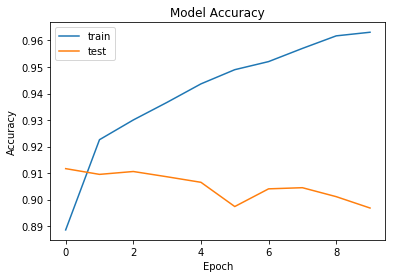

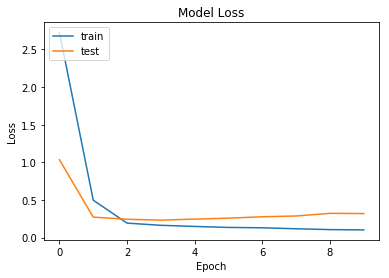

Accuracy: 89.99%


In [81]:
# Create the model
# regularizers = [L1L2(l1=0.0, l2=0.0), L1L2(l1=0.01, l2=0.0), L1L2(l1=0.0, l2=0.01), L1L2(l1=0.01, l2=0.01)]

embedding_vector_length = 32
model1 = Sequential()
model1.add(Embedding(top_words_count, embedding_vector_length, input_length=max_review_length))
model2.add(Dropout(0.75))
model1.add(LSTM(100, bias_regularizer=L1L2(l1=0.0, l2=0.05)))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

trainModel(model=model1)

# Model 2: Multiple Layer LSTM Architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 600, 32)           160000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 600, 32)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 600, 200)          186400    
_________________________________________________________________
dropout_6 (Dropout)          (None, 600, 200)          0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 150)               210600    
_________________________________________________________________
dropout_7 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 151       
Total para

C:\Users\Anand\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 46899 samples, validate on 23101 samples
Epoch 1/10
46899/46899 [==============================] - 1253s 27ms/step - loss: 8.8642 - acc: 0.8755 - val_loss: 3.0585 - val_acc: 0.9051
Epoch 2/10
46899/46899 [==============================] - 1248s 27ms/step - loss: 1.2711 - acc: 0.9048 - val_loss: 0.3870 - val_acc: 0.9109
Epoch 3/10
46899/46899 [==============================] - 1248s 27ms/step - loss: 0.2813 - acc: 0.9062 - val_loss: 0.2515 - val_acc: 0.9030
Epoch 4/10
46899/46899 [==============================] - 1248s 27ms/step - loss: 0.2211 - acc: 0.9133 - val_loss: 0.2355 - val_acc: 0.9084
Epoch 5/10
46899/46899 [==============================] - 1248s 27ms/step - loss: 0.2146 - acc: 0.9157 - val_loss: 0.2282 - val_acc: 0.9094
Epoch 6/10
46899/46899 [==============================] - 1248s 27ms/step - loss: 0.2176 - acc: 0.9152 - val_loss: 0.2294 - val_acc: 0.9081
Epoch 7/10
46899/46899 [==============================] - 1248s 27ms/step - loss: 0.2045 - acc: 0.9207 - val_l

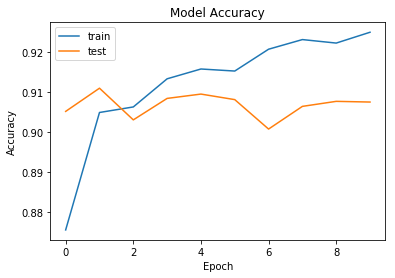

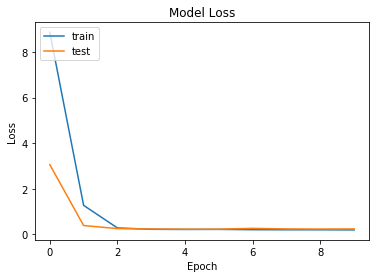

Accuracy: 91.07%


In [82]:
# Create the model
from keras.layers import Dropout

embedding_vector_length = 32
model2 = Sequential()
model2.add(Embedding(top_words_count, embedding_vector_length, input_length=max_review_length))
model2.add(Dropout(0.75))
model2.add(LSTM(200, bias_regularizer=L1L2(l1=0.0, l2=0.05), return_sequences=True))
model2.add(Dropout(0.75))
model2.add(LSTM(150, bias_regularizer=L1L2(l1=0.0, l2=0.05)))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

trainModel(model=model2)

# Model 3: Multi-Layer Neuron-Dense LSTM Architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 600, 32)           160000    
_________________________________________________________________
lstm_28 (LSTM)               (None, 600, 512)          1116160   
_________________________________________________________________
lstm_29 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 2,063,873
Trainable params: 2,063,873
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Anand\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 46899 samples, validate on 23101 samples
Epoch 1/10
46899/46899 [==============================] - 2246s 48ms/step - loss: 19.0439 - acc: 0.8877 - val_loss: 6.4428 - val_acc: 0.8999
Epoch 2/10
46899/46899 [==============================] - 2245s 48ms/step - loss: 2.4640 - acc: 0.9198 - val_loss: 0.5971 - val_acc: 0.9080
Epoch 3/10
46899/46899 [==============================] - 2245s 48ms/step - loss: 0.2778 - acc: 0.9267 - val_loss: 0.2457 - val_acc: 0.9068
Epoch 4/10
46899/46899 [==============================] - 2269s 48ms/step - loss: 0.1726 - acc: 0.9349 - val_loss: 0.2433 - val_acc: 0.9085
Epoch 5/10
46899/46899 [==============================] - 2273s 48ms/step - loss: 0.1464 - acc: 0.9462 - val_loss: 0.2558 - val_acc: 0.9054
Epoch 6/10
46899/46899 [==============================] - 2335s 50ms/step - loss: 0.1301 - acc: 0.9535 - val_loss: 0.2739 - val_acc: 0.8994
Epoch 7/10
46899/46899 [==============================] - 2279s 49ms/step - loss: 0.1178 - acc: 0.9582 - val_

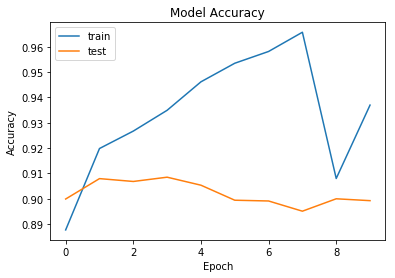

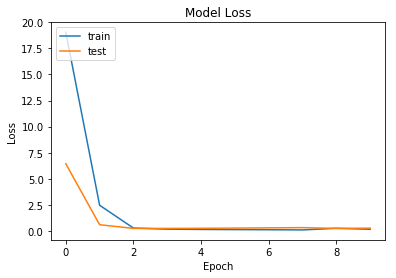

Accuracy: 89.97%


In [84]:
# Create the model
embedding_vector_length = 32
model3 = Sequential()
model3.add(Embedding(top_words_count, embedding_vector_length, input_length=max_review_length))
model2.add(Dropout(0.5))
model3.add(LSTM(512, bias_regularizer=L1L2(l1=0.0, l2=0.05), return_sequences=True))
model2.add(Dropout(0.5))
model3.add(LSTM(256, bias_regularizer=L1L2(l1=0.0, l2=0.05)))
model2.add(Dropout(0.4))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())

trainModel(model=model3)


# Summary Statistics

 Model  | Architecture | Test Metric |
------------- |:----------:|:-----------------:|
**M1: Single Layer LSTM** | 100 (1) LSTM stack  | **Accuracy = 89.99%**, Train Accuracy after 10th Epoch= 96.31|
**M2: Double Layer LSTM** | 200 (1) -150 (2) LSTM stack | **Accuracy = 91.07%**, Train Accuracy after 10th Epoch= 92.5%|
**M3: Multi-Layer Neuron-Dense LSTM** | 512 (1) -256 (2) LSTM stack | **Accuracy = 89.97%**, Train Accuracy after 10th Epoch= 93.7%|

# Conclusion

1. Three architectures with single layer and double layer LSTMs are used to train frequency-encoded Amazon Review dataset.
2. **Double-Layer LSTM Architecture obtained highest accuracy** on validation dataset.
3. A **single layer stack of 100 LSTMs (M1) fetched a commendable validation accuracy** of 89.99%.
4. The **validation accuracy of multi layer neuron dense LSTM stack (M3) fell to 89.97%**, though it showed a hike in training accuracy, 93.7%. The increase in training accuracy and reduction in test accuracy points to slight overfitting on the train data.
5. The **slight improvement in accuracy of Model 2 may not be worth the extra time spent on training such a stack-dense model. Hence, Model 1 with an accuracy of 90% is the architecture of choice.**
